# Porcupine Neural Networks

The code here implements a general PNN and performs the experiments corresponding to Figure 8 in the paper.

We generated one set of true labels using a dense 3-layer network with $d = 15$ inputs and $k = 20$ hidden neurons. We generated 10000 ground truth samples using a set of randomly chosen weights. As a point of reference, we report the MSE losses in the cases where 0 and the label is predicted for all labels, respectively. 

We explored how PNNs can approximate these input-output relationships. We tested dense architectures with $k = 10, 20, 30, \dots, 100$ hidden neurons. For each value of $k$, we performed 25 trials of the following:

1. Initialize $k/2$ random $d$-dimensional unit-L2-norm weight vectors
2. Assign each weight vector to two hidden neurons. For the first neuron, scale the vector by a random number sampled uniformly between 0 and 1. For the second neuron, scale the vector by a random number sampled uniformly between -1 and 0. 
3. Train the network via stochastic gradient descent using batches of size 100, 100 training epochs, no momentum, and a learning rate of 1e-3 which decays every epoch at a rate of 0.95 every 390 epochs. 
4. Check to make sure that final weights lie along the same lines as initial weights. Ignore results if this is not the case.
5. Repeat 2-4 10 times. Return the minimum loss over these initializations

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,pickle
import matplotlib.pyplot as plt
import arch,dl_utils,utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 1

%matplotlib inline

maindir = './temp_PNN/'

In [2]:
# Same as graph_builder_wrapper except for sparser structures
# CURRENTLY ONLY WORKS WITH mlp_noreluout_lastlayernottrainable
# (M is a mask for only the weights from input to hidden 1 layers)
def graph_builder_wrapper_PNN(input_dict,build_func=arch.mlp,lr_initial=0.01,max_save=100):
    graph = build_func(input_dict)
    
    # Loss
    y = tf.placeholder(tf.float32, shape=[None,1])
    total_loss = dl_utils.loss(y, graph['yhat'])
    
    # W gap
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    total_w_gap = dl_utils.w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    
    # Find unit vectors
    u = graph['weights1'] / tf.sqrt(tf.reduce_sum(tf.square(graph['weights1']), 0, keep_dims=True))
    
    # Optimizer
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(total_loss)
    modified_grads = []
    for gv in grads:
        if gv[0] is None: modified_grads.append(gv)
        else: 
            # Project gradients along unit vectors
            alpha = tf.diag_part(tf.matmul(tf.transpose(u),gv[0]))
            update = u*alpha
            modified_grads.append((update, gv[1]))
            
    opt_step = optimizer.apply_gradients(modified_grads)
    
    graph['y'] = y
    graph['w'] = w
    graph['u'] = u
    graph['grads'] = [i for i in grads if i[0] is not None]
    graph['modified_grads'] = [i for i in modified_grads if i[0] is not None]
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    graph['saver'] = tf.train.Saver(max_to_keep=100)
    return graph

In [3]:
# Generate true labels using dense networks

np.random.seed(0)
d = 15
k1 = 20
input_dict = dict(p=d,h=k1)
w_true = {'weights1':np.random.normal(0,1./np.sqrt(d),[d,k1]),
          'weights2':np.ones([k1,1])}

N = 10000
X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=0)
Y = dl_utils.generate_output(X,w_true,input_dict,build_func=arch.mlp_noreluout_lastlayernottrainable)
cnorm = np.mean(np.square(Y))

In [4]:
num_sims = 25 # number of simulations
num_scale_redraws = 10
N = 10000      # number of samples

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
d = 15    # number of inputs

# k2 is the number of hidden neurons (even number)
list_k2 = np.arange(10,101,10)

In [5]:
# Used to check to make sure final weights are aligned with initial weights
def check_to_see_if_col_are_same_line(X1,X2,verbose=True):
    u1 = X1 / np.linalg.norm(X1,axis=0)
    u2 = X2 / np.linalg.norm(X2,axis=0)
    dot_products = np.abs(np.diag(np.dot(u1.T,u2)))
    if verbose:
        for i in dot_products: print(i)
        if np.all(np.isclose(dot_products,1)):
            print('columns along same line')
        else:
            print('columns not along same line')            
    return dot_products

In [6]:
start = time.time()
outputs = {k2:[] for k2 in list_k2}
for i,k2 in enumerate(list_k2):
    
    for t in range(num_sims):
        
        run_dict = {}
        
        input_dict = dict(p=d,h=k2)
        
        np.random.seed((k2-1)*num_sims+t+1)

        # initialize unit vectors corresponding to lines
        w_init_u = np.random.normal(0,1,[d,k2/2])
        w_init_u /= np.linalg.norm(w_init_u,axis=0)
        w_init_u = np.repeat(w_init_u, 2,axis=1)
        
        # rescale a few times, each time drawing the scaling randomly
        num_pass = 0
        num_fail = 0
        while num_pass < num_scale_redraws:
            alpha = np.random.uniform(0,1,k2)
            for ii in range(0,len(alpha),2): alpha[ii] *= -1
            w_init = alpha*w_init_u
            w_init = {'weights1':w_init.astype(np.float32),
                      'weights2':np.ones([k2,1]).astype(np.float32)}
            
            # Build and train network (if it does not already exist)
            savedir = '%snuminput%s_numepoch%s/initialization%s_scalesamp%s_numhidden%s/' \
                      %(maindir,d,num_epochs,t,num_pass,k2)
                
            if os.path.isdir(savedir):
                w_hat,final_train_loss,_ = dl_utils.get_train_out(X,Y,w_init,
                                                              input_dict,
                                                              savedir,
                                                              build_func)
                out = {5:final_train_loss,2:w_hat}
            
            else:
                tf.reset_default_graph()
                with tf.device("/gpu:%s"%(gpu_id)):
                    graph = graph_builder_wrapper_PNN(input_dict,build_func=build_func)
                    out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_init,w_init,
                                         savedir=savedir,lr_initial=1e-3,verbose=False)
                
            # check to make sure final weights are aligned with initial weights
            # otherwise redo the run
            w1 = out[2]['weights1']
            w2 = w_init['weights1']
            dot_prods = check_to_see_if_col_are_same_line(w1,w2,verbose=False)
            if np.all(np.isclose(dot_prods,np.ones(k2),atol=1e-3)):
                num_pass += 1
                run_dict[num_pass] = {'out':out,'w_init':w_init}
            else:
                num_fail += 1
                os.system('rm -rf %s'%(savedir))

            print('\rk2 = %s, %s/%s sims done, %s/%s passes, %s fails (%.2f s elapsed)'\
                  %(k2,t+1,num_sims,num_pass,num_scale_redraws,
                    num_fail,time.time()-start),end='')                
                
        run_dict['num_fail'] = num_fail
        outputs[k2].append(run_dict)
        
pickle.dump(outputs,file('%snuminput%s_numepoch%s/outputs.pickle'%(maindir,d,num_epochs),'wb'))
# outputs = pickle.load(file('%snuminput%s_numepoch%s/outputs.pickle'%(maindir,d,num_epochs)))

k2 = 100, 25/25 sims done, 10/10 passes, 0 fails (236.47 s elapsed)

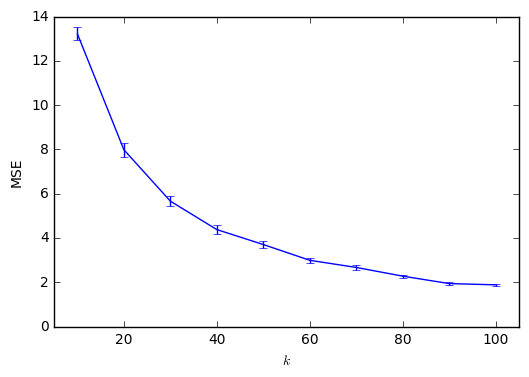

In [7]:
# Take minimum of losses over 10 scaling factor redraws
min_losses = np.zeros((len(list_k2),num_sims))
for ik,k2 in enumerate(list_k2):
    for i in range(num_sims):
        min_losses[ik,i] = min([outputs[k2][i][j]['out'][5] \
                                for j in range(1,1+num_scale_redraws)])
        
# Plot with error bars
plt.errorbar(list_k2, np.mean(min_losses,1), yerr=np.std(min_losses,1)/np.sqrt(num_sims))
plt.xlabel('$k$')
plt.ylabel('MSE')
plt.xlim(5,105)
plt.savefig('Figures/fig_pnn_msecurve.pdf', format='pdf', dpi=500, bbox_inches='tight')

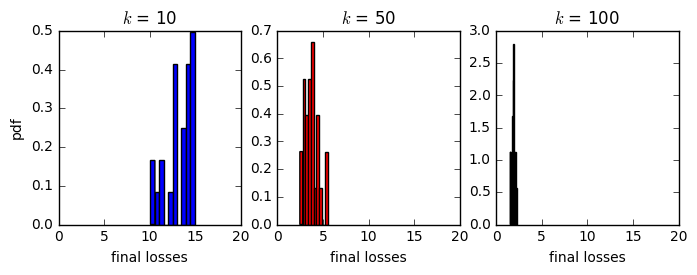

In [8]:
# Look at k2 = 10, 50, 100 cases
list_k2_select = [10,50,100]
d = {list_k2[i]:i for i in range(len(list_k2))}

plt.figure(figsize=(8,2.5))
colors = ['b','r','g']
for j,k2 in enumerate(list_k2_select):
    plt.subplot(1,3,j+1)
    plt.hist(min_losses[d[k2],:], color = colors[j], normed=True)
    plt.xlim(0,20)
    plt.title('$k$ = %s'%(k2))
    if j == 0: plt.ylabel('pdf')
    plt.xlabel('final losses')
plt.savefig('Figures/fig_pnn_losshist.pdf', format='pdf', dpi=500, bbox_inches='tight')

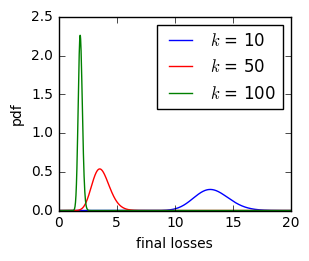

In [9]:
# Fit gamma curves to the histograms
from scipy.stats import gamma
def fit_gamma(data,xmax):
    x = np.linspace(0, xmax, 1000)
    param = gamma.fit(data, floc=0)
    return gamma.pdf(x, *param)

plt.figure(figsize=(3,2.5))
colors = ['b','r','g']
for j,k2 in enumerate(list_k2_select):
    curve = fit_gamma(min_losses[d[k2]],20)
    plt.plot(np.linspace(0, 20, 1000),curve,c=colors[j],label='$k$ = %s'%(k2))
plt.legend()
plt.xlabel('final losses')
plt.ylabel('pdf')
plt.savefig('Figures/fig_pnn_losshist_curvefit.pdf', format='pdf', dpi=500, bbox_inches='tight')

In [10]:
print('loss obtained if we always predict mean of labels: %.2f'%(np.mean(np.square(Y-np.mean(Y)))))
print('loss obtained if we always predict 0: %.2f'%(np.mean(np.square(Y))))

loss obtained if we always predict mean of labels: 12.33
loss obtained if we always predict 0: 73.77
